# 导入官方库训练

In [1]:
import warnings
warnings.filterwarnings("ignore")

# preprocess
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample

# model
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# socre
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, precision_score, recall_score, auc

# figure
import matplotlib.pyplot as plt

# 定义辅助函数

In [29]:
# 训练的辅助函数
def trainHelper(model, x_train, y_train):
    print("=== train ===")
    start = time.time()
    model.fit(x_train, y_train)
    trainingTime = time.time() - start
    print("Training time: ", trainingTime, "sec\n")
    return model, trainingTime


# 推理的辅助函数
def inferenceHelper(model, x_test, y_test):
    print("=== inference ===")
    start_time_inference = time.time()
    y_pred = model.predict(x_test)
    inference_time = time.time() - start_time_inference
    # 计算F1, precision和recall
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print("F1 Score: ", f1)
    print("precision: ", precision)
    print("recall: ", recall)
    print(f"Inference Time: {inference_time} sec\n")

    return f1,precision,recall,inference_time


# gridSearch的辅助函数
def gridSearchHelper(model, p_grid, x_train, y_train):
    print("=== grid search ===")
    grid_search = GridSearchCV(estimator=model, param_grid=p_grid, scoring="f1", cv=5)
    start = time.time()
    grid_search.fit(x_train, y_train)
    searchTime = time.time() - start
    print("grid search time: ", searchTime, "sec\n")
    return grid_search.best_params_, searchTime


def plot_PRC(model, x_test, y_test):
    y_score = model.predict_proba(x_test)

    # 计算精确率和召回率和AUPRC
    precision, recall, _ = precision_recall_curve(y_test, y_score[:, 1])
    average_precision = average_precision_score(y_test, y_score[:, 1])
    print("AUPRC:", average_precision)

    # 绘制PRC曲线
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

    return average_precision

def printAsTable(origin_data, accelerate_data):
    print("{:<10} {:<15} {:<15}".format('Model', 'origin', 'oneAPI'))
    print("-" * 40)

    models = ['LR', 'DT', 'RF', 'SVM', 'KNN']
    for i in range(len(models)):
        print("{:<10} {:<15.4f} {:<15.4f}".format(models[i], origin_data[i], accelerate_data[i]))

def plotCompareTime(title, origin, accelerated):
    save_path = "resample/" + title + ".png"
    unit_1 = [1,1,1,1,1]
    bar_width = 0.35
    opacity = 0.8
    algorithms = ['LR', 'DT', 'RF', 'SVM', 'KNN']
    speedup = [o/a for o, a in zip(origin, accelerated)]
    fig, ax = plt.subplots(figsize=(8,8))

    rects1 = ax.bar(np.arange(len(unit_1)), unit_1, bar_width,
                    alpha=opacity, color='#1893aa', align='center')
    rects2 = ax.bar(np.arange(len(speedup)) + bar_width, speedup, bar_width,
                    alpha=opacity, color='#225fe2', align='center')

    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Speedup Ratio')
    ax.set_title(title + ' Comparison: origin/oneAPI')
    # ax.set_xticks(x)
    ax.set_xticks(np.arange(len(unit_1)) + bar_width / 2)
    ax.set_xticklabels(algorithms)
    ax.legend((rects1[0], rects2[0]), ('origin', 'oneAPI'))

    for rect in rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plotCompareScore(title, origin, accelerated):
    save_path = "resample/" + title + ".png" 
    unit_1 = [1,1,1,1,1]
    bar_width = 0.35
    opacity = 0.8
    algorithms = ['LR', 'DT', 'RF', 'SVM', 'KNN']
    speedup = [a/o for o, a in zip(origin, accelerated)]
    fig, ax = plt.subplots(figsize=(8,8))

    rects1 = ax.bar(np.arange(len(unit_1)), unit_1, bar_width,
                    alpha=opacity, color='#1893aa', align='center')
    rects2 = ax.bar(np.arange(len(speedup)) + bar_width, speedup, bar_width,
                    alpha=opacity, color='#225fe2', align='center')

    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Speedup Ratio')
    ax.set_title(title + ' Comparison: origin/oneAPI')
    # ax.set_xticks(x)
    ax.set_xticks(np.arange(len(unit_1)) + bar_width / 2)
    ax.set_xticklabels(algorithms)
    ax.legend((rects1[0], rects2[0]), ('origin', 'oneAPI'))

    for rect in rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    

# 训练过程
1. 读入csv数据，去除无关列Time
2. 使用**重采样的数据集进行训练**
3. 预测时，使用原始数据集  

In [3]:
print("loading data...")
data = pd.read_csv('creditcard.csv')
data = data.drop(columns=['Time'], axis=1)
# Amount列值缩放到[-1,1]区间
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
x = data.drop(columns=['Class'], axis=1) 
y = data['Class']

x_test = x
y_test = y
# x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.3, random_state=42)

# 对数据下采样，比列为1:9
majority_class = data[data.Class == 0]
minority_class = data[data.Class == 1]
print("number of majority_class data: ", len(majority_class))
print("number of minority_class data: ", len(minority_class))
print("fraction of minority class: ", len(minority_class)/len(data))
majority_downsampled = resample(majority_class, replace=False, n_samples=len(minority_class)*9, random_state=123)
majority_downsampled = pd.DataFrame(majority_downsampled, columns=data.columns) 
downsampled_data = pd.concat([majority_downsampled, minority_class])

x_train_down = downsampled_data.drop(columns=['Class'], axis=1)
y_train_down = downsampled_data["Class"]

print("number of downSample data = ", len(downsampled_data))
print("loading complete!")


loading data...
number of majority_class data:  284315
number of minority_class data:  492
fraction of minority class:  0.001727485630620034
number of downSample data =  4920
loading complete!


2. 使用不同算法训练并预测
   
   2.1. 逻辑回归

logistic regression:
=== grid search ===
grid search time:  7.273085355758667 sec

=== train ===
Training time:  0.024288654327392578 sec

=== inference ===
F1 Score:  0.5846579129232896
precision:  0.44293193717277485
recall:  0.8597560975609756
Inference Time: 0.05008053779602051 sec

AUPRC: 0.7471883996228341


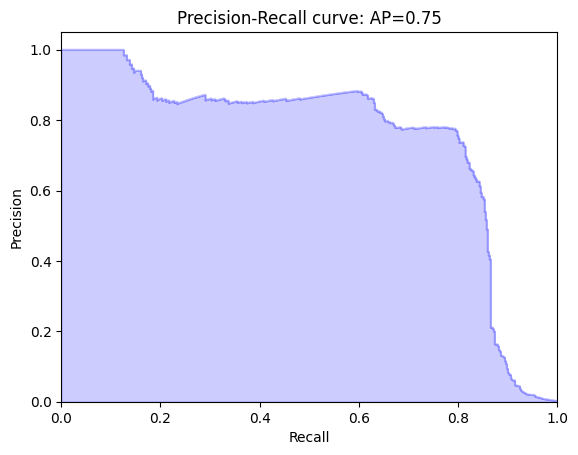

In [4]:
print("logistic regression:")
# 参数搜索优化
param_grid_LR = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'saga']
}
best_para_LR, search_time_LR = gridSearchHelper(LogisticRegression(random_state=42), param_grid_LR,x_train_down, y_train_down)

# 使用参数搜索的结果
LR_model = LogisticRegression(**best_para_LR)
LR_model, training_time_LR = trainHelper(LR_model,x_train_down, y_train_down)
f1_LR,precision_LR,recall_LR,inference_time_LR  = inferenceHelper(LR_model, x_test, y_test)
auprc_LR = plot_PRC(LR_model, x_test, y_test)


2.2 决策树

decision tree:
=== grid search ===
grid search time:  160.09675478935242 sec

=== train ===
Training time:  0.09593653678894043 sec

=== inference ===
F1 Score:  0.49461145774248433
precision:  0.3430369787568843
recall:  0.8861788617886179
Inference Time: 0.05513930320739746 sec

AUPRC: 0.3488049569191313


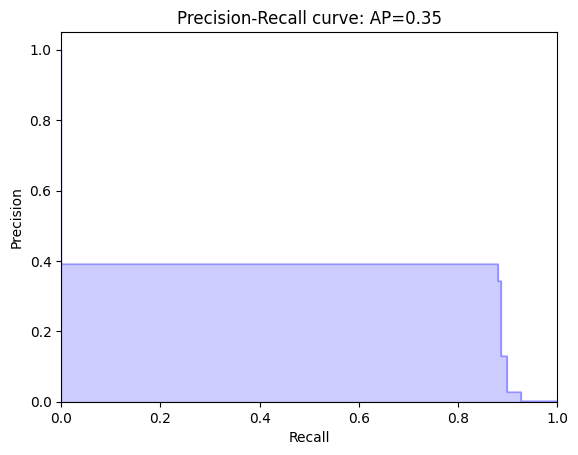

In [5]:
print("decision tree:")
param_grid_DT = {
    'criterion': ['gini', 'entropy', "log_loss"],
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 3, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4],
}

best_para_DT, search_time_DT = gridSearchHelper(DecisionTreeClassifier(random_state=42),param_grid_DT,x_train_down, y_train_down)

DT_model = DecisionTreeClassifier(**best_para_DT)
DT_model, training_time_DT = trainHelper(DT_model, x_train_down, y_train_down)
f1_DT, precision_DT, recall_DT,inference_time_DT  = inferenceHelper(DT_model, x_test, y_test)
auprc_DT = plot_PRC(DT_model, x_test, y_test)


2.3 随机森林

Random Forest Classifier
=== grid search ===
grid search time:  721.3495788574219 sec

=== train ===
Training time:  2.079598903656006 sec

=== inference ===
F1 Score:  0.7102502017756255
precision:  0.5890227576974565
recall:  0.8943089430894309
Inference Time: 1.432697057723999 sec

AUPRC: 0.7978843542860654


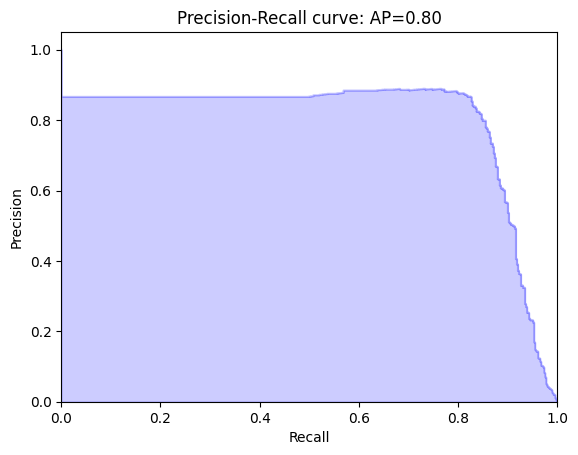

In [6]:
print("Random Forest Classifier")
param_grid_RF = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}
best_para_RF, search_time_RF = gridSearchHelper(RandomForestClassifier(random_state=42),param_grid_RF,x_train_down, y_train_down)

RF_model = RandomForestClassifier(**best_para_RF)
RF_model, training_time_RF = trainHelper(RF_model, x_train_down, y_train_down)
f1_RF, precision_RF, recall_RF,inference_time_RF  = inferenceHelper(RF_model, x_test, y_test)
auprc_RF = plot_PRC(RF_model, x_test, y_test)

2.4 SVM

Support vector machine
=== grid search ===
grid search time:  90.71455121040344 sec

=== train ===
Training time:  0.42334675788879395 sec

=== inference ===
F1 Score:  0.7102502017756255
precision:  0.5890227576974565
recall:  0.8943089430894309
Inference Time: 1.4400532245635986 sec

AUPRC: 0.7452344934950936


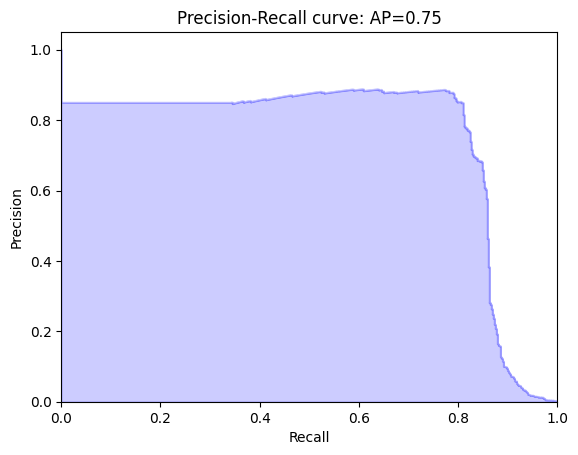

In [7]:
print("Support vector machine")
param_grid_SVM = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10]
}
best_para_SVM, search_time_SVM = gridSearchHelper(SVC(random_state=42),param_grid_SVM,x_train_down, y_train_down)

SVM_model = SVC(**best_para_SVM, probability=True)
SVM_model, training_time_SVM = trainHelper(SVM_model, x_train_down, y_train_down)
f1_SVM, precision_SVM, recall_SVM, inference_time_SVM  = inferenceHelper(RF_model, x_test, y_test)
auprc_SVM = plot_PRC(SVM_model, x_test, y_test)

2.5 KNN

=== grid search ===
grid search time:  1.0624923706054688 sec

=== train ===
Training time:  0.001859903335571289 sec

=== inference ===
F1 Score:  0.6944248412138321
precision:  0.5318918918918919
recall:  1.0
Inference Time: 1.1087913513183594 sec

AUPRC: 0.8241273960248506


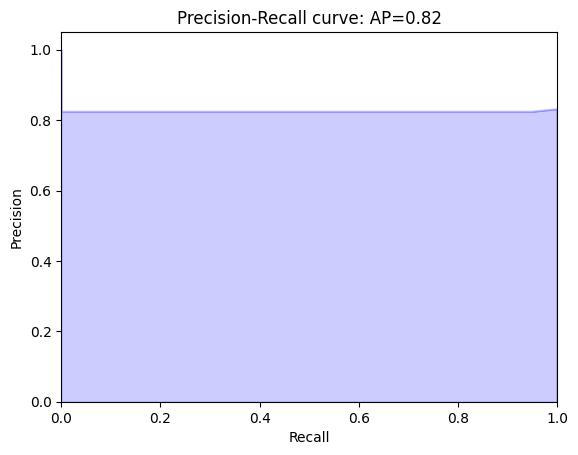

In [8]:
param_grid_KNN = {
    'n_neighbors': [5, 10, 15], 
    'weights': ['uniform', 'distance']
}

best_para_KNN, search_time_KNN = gridSearchHelper(KNeighborsClassifier(), param_grid_KNN, x_train_down, y_train_down)

KNN_model = KNeighborsClassifier(**best_para_KNN)
KNN_model, training_time_KNN = trainHelper(KNN_model, x_train_down, y_train_down)
f1_KNN, precision_KNN, recall_KNN,inference_time_KNN  = inferenceHelper(KNN_model, x_test, y_test)
auprc_KNN = plot_PRC(KNN_model, x_test, y_test)

# 以下使用oneAPI库加速

In [9]:
import modin.pandas as pd
import modin.config as cfg
cfg.StorageFormat.put('hdk')
from sklearnex import patch_sklearn
patch_sklearn()

import warnings
warnings.filterwarnings("ignore")

# preprocess
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample

# model
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# socre
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, precision_score, recall_score, auc

# figure
import matplotlib.pyplot as plt

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 读取和预处理数据

In [10]:
print("loading data...")
data = pd.read_csv('creditcard.csv')
data = data.drop(columns=['Time'], axis=1)
# Amount列值缩放到[-1,1]区间
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
x = data.drop(columns=['Class'], axis=1) 
y = data['Class']

x_test = x
y_test = y
# x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.3, random_state=42)

# 对数据下采样，比列为1:9
majority_class = data[data.Class == 0]
minority_class = data[data.Class == 1]
print("number of majority_class data: ", len(majority_class))
print("number of minority_class data: ", len(minority_class))
print("fraction of minority class: ", len(minority_class)/len(data))
majority_downsampled = resample(majority_class, replace=False, n_samples=len(minority_class)*9, random_state=123)
majority_downsampled = pd.DataFrame(majority_downsampled, columns=data.columns) 
downsampled_data = pd.concat([majority_downsampled, minority_class])

x_train_down = downsampled_data.drop(columns=['Class'], axis=1)
y_train_down = downsampled_data["Class"]

print("number of downSample data = ", len(downsampled_data))
print("loading complete!")


loading data...
number of majority_class data:  284315
number of minority_class data:  492
fraction of minority class:  0.001727485630620034
number of downSample data =  4920
loading complete!


2.1 逻辑回归

logistic regression:
=== grid search ===
grid search time:  5.367825984954834 sec

=== train ===
Training time:  0.012550115585327148 sec

=== inference ===
F1 Score:  0.5846579129232896
precision:  0.44293193717277485
recall:  0.8597560975609756
Inference Time: 0.038216590881347656 sec

AUPRC: 0.7471654231422259


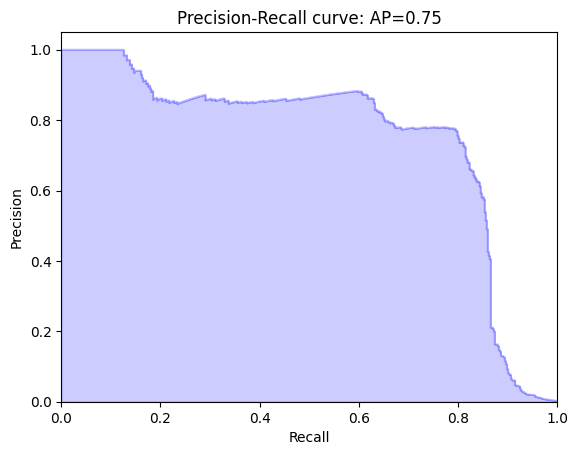

In [11]:
print("logistic regression:")
# 参数搜索优化
param_grid_LR = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'saga']
}
best_para_LR, search_time_LR_a = gridSearchHelper(LogisticRegression(random_state=42), param_grid_LR,x_train_down, y_train_down)

# 使用参数搜索的结果
LR_model = LogisticRegression(**best_para_LR)
LR_model, training_time_LR_a = trainHelper(LR_model,x_train_down, y_train_down)
f1_LR_a, precision_LR_a, recall_LR_a, inference_time_LR_a  = inferenceHelper(LR_model, x_test, y_test)
auprc_LR_a = plot_PRC(LR_model, x_test, y_test)

2.2 决策树

decision tree:
=== grid search ===
grid search time:  162.67543506622314 sec

=== train ===
Training time:  0.09676599502563477 sec

=== inference ===
F1 Score:  0.49573621375781696
precision:  0.3441199684293607
recall:  0.8861788617886179
Inference Time: 0.049069881439208984 sec

AUPRC: 0.35006200482849215


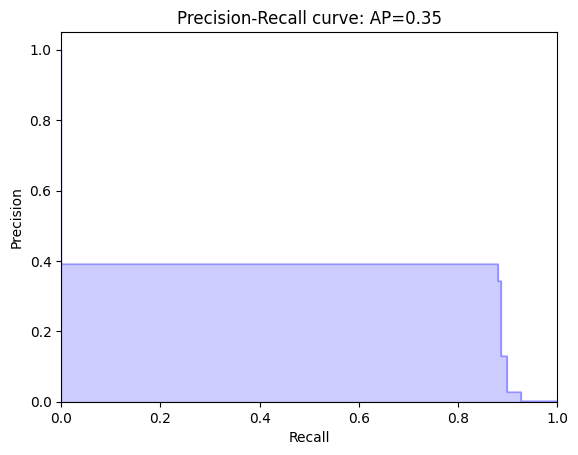

In [12]:
print("decision tree:")
param_grid_DT = {
    'criterion': ['gini', 'entropy', "log_loss"],
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 3, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4],
}

best_para_DT, search_time_DT_a = gridSearchHelper(DecisionTreeClassifier(random_state=42),param_grid_DT,x_train_down, y_train_down)

DT_model_a = DecisionTreeClassifier(**best_para_DT)
DT_model_a, training_time_DT_a = trainHelper(DT_model, x_train_down, y_train_down)
f1_DT_a, precision_DT_a, recall_DT_a, inference_time_DT_a  = inferenceHelper(DT_model, x_test, y_test)
auprc_DT_a = plot_PRC(DT_model, x_test, y_test)


2.3 随机森林

Random Forest Classifier
=== grid search ===
grid search time:  127.08617734909058 sec

=== train ===
Training time:  0.2711164951324463 sec

=== inference ===
F1 Score:  0.7069351230425055
precision:  0.558303886925795
recall:  0.9634146341463414
Inference Time: 0.2921621799468994 sec

AUPRC: 0.8467236761427657


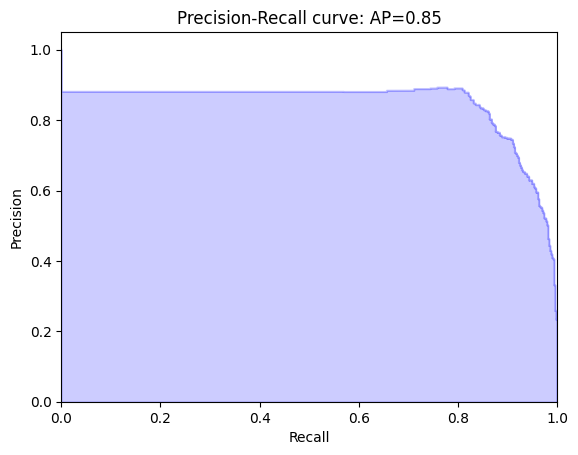

In [13]:
print("Random Forest Classifier")
param_grid_RF = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}
best_para_RF, search_time_RF_a = gridSearchHelper(RandomForestClassifier(random_state=42),param_grid_RF,x_train_down, y_train_down)

RF_model = RandomForestClassifier(**best_para_RF)
RF_model, training_time_RF_a = trainHelper(RF_model, x_train_down, y_train_down)
f1_RF_a, precision_RF_a, recall_RF_a, inference_time_RF_a  = inferenceHelper(RF_model, x_test, y_test)
auprc_RF_a = plot_PRC(RF_model, x_test, y_test)

2.4 SVM

Support vector machine
=== grid search ===
grid search time:  40.798986196517944 sec

=== train ===
Training time:  0.4196341037750244 sec

=== inference ===
F1 Score:  0.7069351230425055
precision:  0.558303886925795
recall:  0.9634146341463414
Inference Time: 0.29553818702697754 sec

AUPRC: 0.7459856729394014


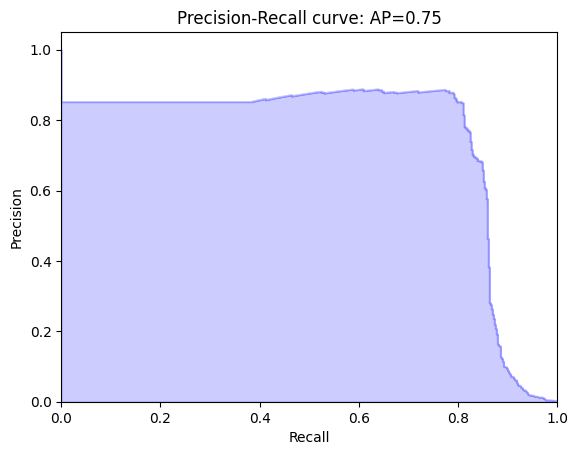

In [14]:
print("Support vector machine")
param_grid_SVM = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10]
}
best_para_SVM, search_time_SVM_a = gridSearchHelper(SVC(random_state=42),param_grid_SVM,x_train_down, y_train_down)

SVM_model_a = SVC(**best_para_SVM, probability=True)
SVM_model_a, training_time_SVM_a = trainHelper(SVM_model, x_train_down, y_train_down)
f1_SVM_a, precision_SVM_a, recall_SVM_a,inference_time_SVM_a  = inferenceHelper(RF_model, x_test, y_test)
auprc_SVM_a = plot_PRC(SVM_model, x_test, y_test)

2.5 KNN

=== grid search ===
grid search time:  0.559220552444458 sec

=== train ===
Training time:  0.0038688182830810547 sec

=== inference ===
F1 Score:  0.5957152729785764
precision:  0.4513089005235602
recall:  0.8760162601626016
Inference Time: 0.3825702667236328 sec

AUPRC: 0.655023001572397


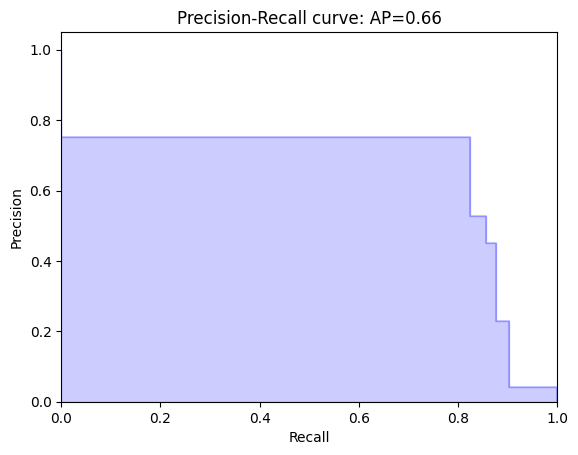

In [15]:
param_grid_KNN = {
    'n_neighbors': [5, 10, 15], 
    'weights': ['uniform', 'distance']
}
best_para_KNN, search_time_KNN_a = gridSearchHelper(KNeighborsClassifier(), param_grid_KNN, x_train_down, y_train_down)

KNN_model = KNeighborsClassifier(**best_para_KNN)
KNN_model, training_time_KNN_a = trainHelper(KNN_model, x_train_down, y_train_down)
f1_KNN_a, precision_KNN_a, recall_KNN_a,inference_time_KNN_a  = inferenceHelper(KNN_model, x_test, y_test)
auprc_KNN_a = plot_PRC(KNN_model, x_test, y_test)

# 比较加速后训练指标与未加速的训练指标

In [16]:
search_time = [search_time_LR, search_time_DT, search_time_RF, search_time_SVM, search_time_KNN]
training_time = [training_time_LR, training_time_DT, training_time_RF, training_time_SVM, training_time_KNN]
inference_time = [inference_time_LR, inference_time_DT, inference_time_RF, inference_time_SVM, inference_time_KNN]
f1 = [f1_LR, f1_DT, f1_RF, f1_SVM, f1_KNN]
precision = [precision_LR, precision_DT, precision_RF,precision_SVM, precision_KNN]
recall = [recall_LR, recall_DT, recall_RF, recall_SVM, recall_KNN]
auprc = [auprc_LR, auprc_DT, auprc_RF, auprc_SVM, auprc_KNN]

search_time_a = [search_time_LR_a, search_time_DT_a, search_time_RF_a, search_time_SVM_a, search_time_KNN_a]
training_time_a = [training_time_LR_a, training_time_DT_a, training_time_RF_a, training_time_SVM_a, training_time_KNN_a]
inference_time_a = [inference_time_RF_a, inference_time_DT_a, inference_time_RF_a, inference_time_RF_a, inference_time_SVM_a, inference_time_KNN_a]
f1_a = [f1_LR_a, f1_DT_a, f1_RF_a, f1_SVM_a, f1_KNN_a]
precision_a = [precision_LR_a, precision_DT_a, precision_RF_a, precision_SVM_a, precision_KNN_a]
recall_a = [recall_LR_a, recall_DT_a, recall_RF_a, recall_SVM_a, recall_KNN_a]
auprc_a = [auprc_LR_a, auprc_DT_a, auprc_RF_a, auprc_SVM_a, auprc_KNN_a]

unit_1 = [1,1,1,1,1]
bar_width = 0.35
opacity = 0.8
algorithms = ['LR', 'DT', 'RF', 'SVM', 'KNN']
x = np.arange(len(algorithms))


训练时间比较

training Time (sec)
Model      origin          oneAPI         
----------------------------------------
LR         0.0243          0.0126         
DT         0.0959          0.0968         
RF         2.0796          0.2711         
SVM        0.4233          0.4196         
KNN        0.0019          0.0039         


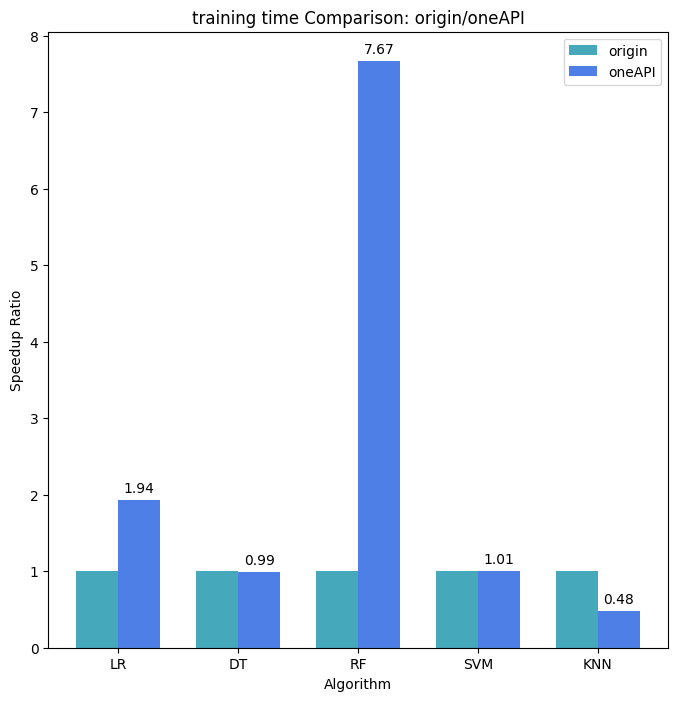

In [30]:
print("training Time (sec)")
printAsTable(training_time, training_time_a)

plotCompareTime("training time", training_time, training_time_a)


推理时间比较


inference Time (sec)
Model      origin          oneAPI         
----------------------------------------
LR         0.0501          0.2922         
DT         0.0551          0.0491         
RF         1.4327          0.2922         
SVM        1.4401          0.2922         
KNN        1.1088          0.2955         


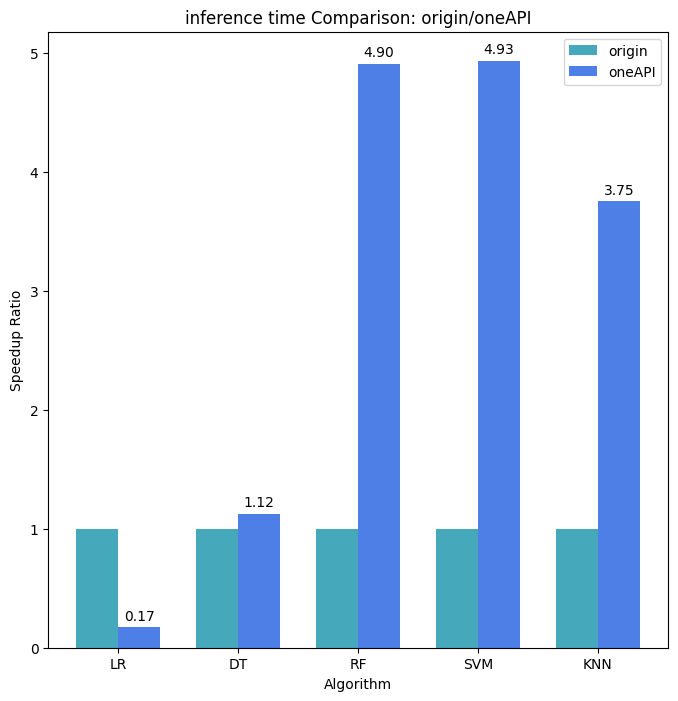

In [31]:
print("inference Time (sec)")
printAsTable(inference_time, inference_time_a)

plotCompareTime("inference time", inference_time, inference_time_a)


grid search时间比较

grid search time (sec)
Model      origin          oneAPI         
----------------------------------------
LR         7.2731          5.3678         
DT         160.0968        162.6754       
RF         721.3496        127.0862       
SVM        90.7146         40.7990        
KNN        1.0625          0.5592         


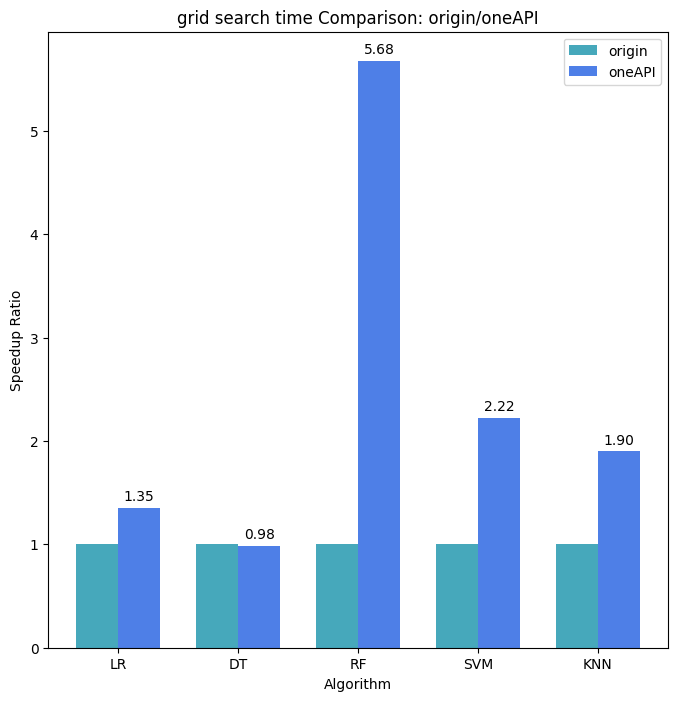

In [32]:
print("grid search time (sec)")
printAsTable(search_time, search_time_a)

plotCompareTime("grid search time", search_time, search_time_a)


AUPRC比较

AUPRC
Model      origin          oneAPI         
----------------------------------------
LR         0.7472          0.7472         
DT         0.3488          0.3501         
RF         0.7979          0.8467         
SVM        0.7452          0.7460         
KNN        0.8241          0.6550         


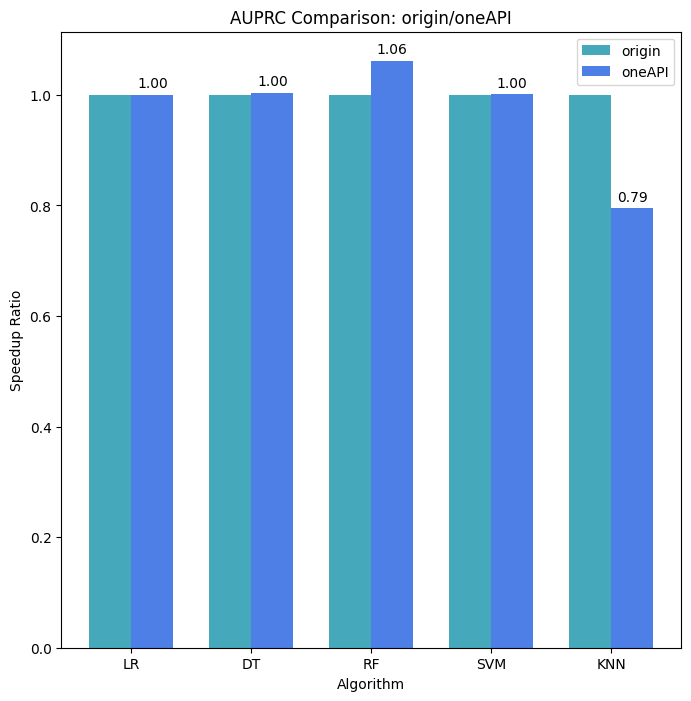

In [33]:
print("AUPRC")
printAsTable(auprc, auprc_a)

plotCompareScore("AUPRC", auprc, auprc_a)


f1 比较

f1 score
Model      origin          oneAPI         
----------------------------------------
LR         0.5847          0.5847         
DT         0.4946          0.4957         
RF         0.7103          0.7069         
SVM        0.7103          0.7069         
KNN        0.6944          0.5957         


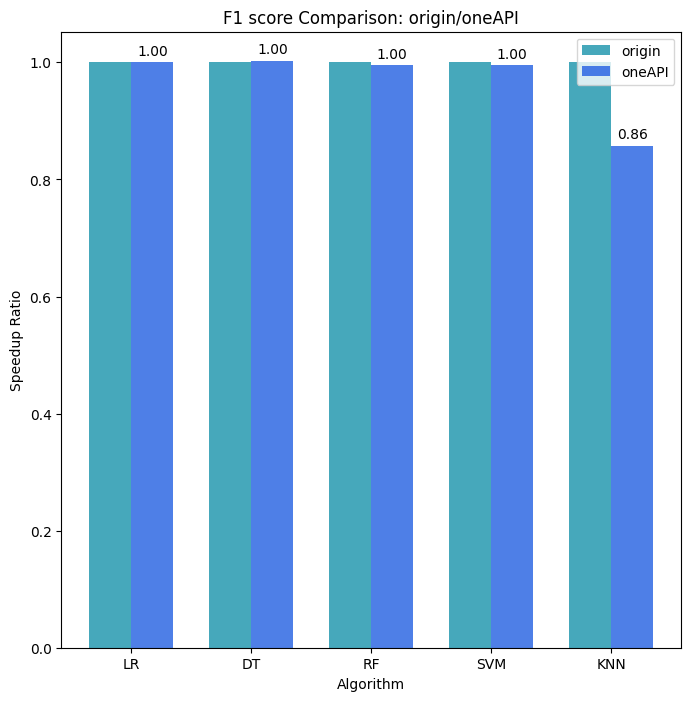

In [34]:
print("f1 score")
printAsTable(f1, f1_a)

plotCompareScore("F1 score", f1, f1_a)


precision 比较

precision
Model      origin          oneAPI         
----------------------------------------
LR         0.4429          0.4429         
DT         0.3430          0.3441         
RF         0.5890          0.5583         
SVM        0.5890          0.5583         
KNN        0.5319          0.4513         


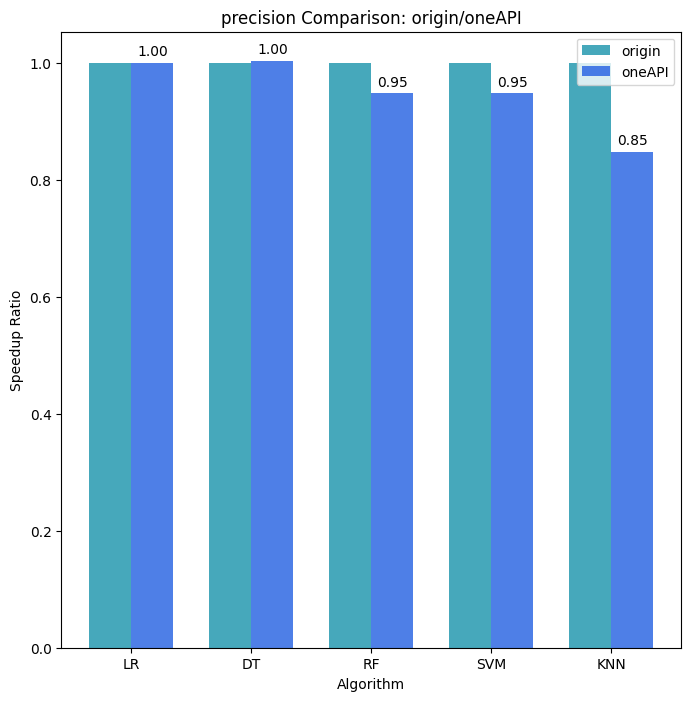

In [36]:
print("precision")
printAsTable(precision, precision_a)

plotCompareScore("precision",precision, precision_a)


recall比较

recall
Model      origin          oneAPI         
----------------------------------------
LR         0.8598          0.8598         
DT         0.8862          0.8862         
RF         0.8943          0.9634         
SVM        0.8943          0.9634         
KNN        1.0000          0.8760         


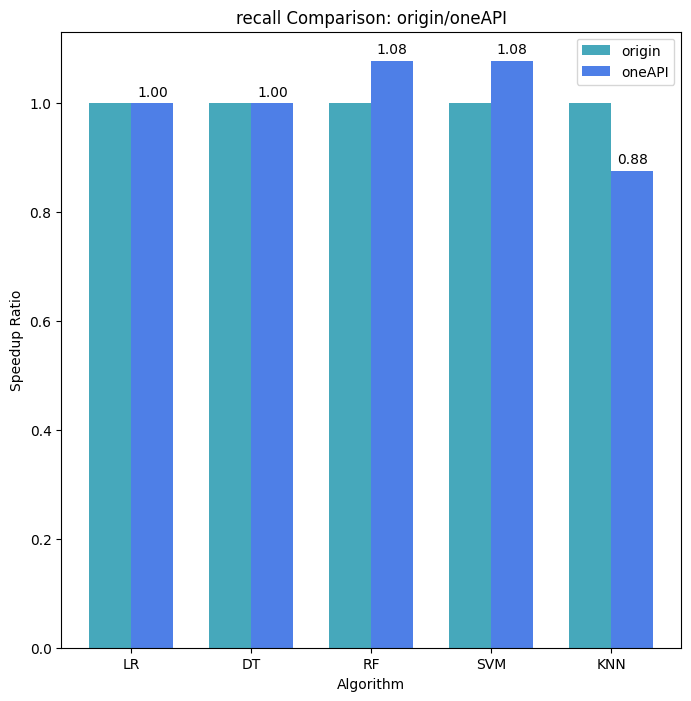

In [37]:
print("recall")
printAsTable(recall, recall_a)

plotCompareScore("recall", recall, recall_a)
